In this notebook, we explore the learning curve for the toxic spans detector

In [1]:
from transformers import RobertaTokenizer, RobertaForTokenClassification
from transformers import BertTokenizer, BertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
import torch

In [2]:
import numpy as np
import pandas as pd

In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
device = torch.device('cuda:0')

In [4]:
model_name = 'roberta-base'  #roberta-base

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
# model = AutoModelForTokenClassification.from_pretrained(model_name)

```
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
labels = torch.tensor([1] * inputs["input_ids"].size(1)).unsqueeze(0)  # Batch size 1
outputs = model(**inputs, labels=labels)
```

# Create labels for tagging

In [7]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize

path = 'data/'

In [8]:
trial = pd.read_csv(path + 'tsd_trial.csv')
train = pd.read_csv(path + 'tsd_train.csv')
# final_test = pd.read_csv(path + 'tsd_test.csv')
final_test = pd.read_csv(path + 'tsd_test_gt.csv')

train['spans'] = train.spans.apply(literal_eval)
trial['spans'] = trial.spans.apply(literal_eval)
final_test['spans'] = final_test.spans.apply(literal_eval)
trial.shape, train.shape, final_test.shape

((690, 2), (7939, 2), (2000, 2))

In [9]:
print(len(set(trial.text).intersection(set(train.text))))
print(len(set(final_test.text).intersection(set(train.text))))

8
0


In [10]:
print((train.spans.apply(len) == 0).mean())
print((trial.spans.apply(len) == 0).mean())

0.06109081748331024
0.06231884057971015


In [11]:
import spans_utils
from importlib import reload
reload(spans_utils)
from spans_utils import display_spans, spans2labels, labels2spans

display_spans(trial.spans[0], trial.text[0])
display_spans(trial.spans[0], trial.text[0])

In [12]:
from tqdm.auto import tqdm, trange

In [14]:
train_labels = [spans2labels(row.text, row.spans, tokenizer) for i, row in tqdm(train.iterrows())]

In [15]:
trial_labels = [spans2labels(row.text, row.spans, tokenizer) for i, row in tqdm(trial.iterrows())]

In [16]:
train['labels'] = train_labels
trial['labels'] = trial_labels

In [17]:
class SpansDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        if self.labels is not None:
            item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings['input_ids'])

In [18]:
train_dataset = SpansDataset(tokenizer(train.text.tolist()), train_labels)
eval_dataset = SpansDataset(tokenizer(trial.text.tolist()), trial_labels)

In [29]:
indices = np.arange(train.shape[0])
np.random.seed(1)
np.random.shuffle(indices)
indices

array([5176,  276, 2441, ..., 3980,  235, 5157])

In [37]:
train_sets = {
    k: SpansDataset(tokenizer(train.text.iloc[indices[:k]].tolist()), [train_labels[i] for i in indices[:k]])
    for k in [10, 30, 100, 300, 1000, 3000, 10000]
}

In [150]:
train_corpora = {
    k: (train.text.iloc[indices[:k]].tolist(), [train_labels[i] for i in indices[:k]])
    for k in [10, 30, 100, 300, 1000, 3000, 10000]
}

In [41]:
final_test_dataset = SpansDataset(tokenizer(final_test.text.tolist()))

In [42]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer, padding=True)

In [43]:
import numpy as np
from semeval2021 import f1

# Train a single-task model

https://github.com/huggingface/notebooks/blob/master/examples/token_classification.ipynb
https://huggingface.co/transformers/custom_datasets.html

In [44]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from transformers.file_utils import cached_property
from typing import Tuple

class TrAr(TrainingArguments):
    @cached_property
    def _setup_devices(self):
        return device

In [45]:
torch.cuda.set_device(device)

In [46]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 2, 19, 23, 2, 10, 243435)

In [49]:
import gc

def cleanup():
    gc.collect()
    torch.cuda.empty_cache()

In [55]:
for k in [10, 30, 100, 300, 1000, 3000, 10000]:
    print(f'Training model on {k} examples')
    print(datetime.now())
    model = AutoModelForTokenClassification.from_pretrained(model_name)
    cleanup()
    model.to(device);
    # first part
    for param in model.roberta.parameters():
        param.requires_grad = False
    MODEL_NAME = f'./models_scale/roberta_single_{k}'
    training_args = TrAr(
        output_dir=MODEL_NAME,   # output directory
        overwrite_output_dir=True,
        num_train_epochs=100_000,            # total # of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=8,   # batch size for evaluation
        warmup_steps=3000,               # number of warmup steps for learning rate scheduler
        weight_decay=1e-8,              # strength of weight decay
        learning_rate=1e-3,
        logging_dir='./logs2',           # directory for storing logs
        logging_steps=50,
        eval_steps=50,
        evaluation_strategy='steps',
        save_total_limit=1,
        load_best_model_at_end=True,
    )
    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_sets[k],         # training dataset
        eval_dataset=eval_dataset,           # evaluation dataset
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0)]
    )
    trainer.train()
    model.save_pretrained(MODEL_NAME + '_head')
    loss_head = trainer.evaluate()['eval_loss']
    
    for param in model.parameters():
        param.requires_grad = True
    print(f'Tuning model on {k} examples')
    training_args = TrAr(
        output_dir=MODEL_NAME,   # output directory
        overwrite_output_dir=True,
        num_train_epochs=100_000,            # total # of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=8,   # batch size for evaluation
        warmup_steps=3000,               # number of warmup steps for learning rate scheduler
        weight_decay=1e-8,              # strength of weight decay
        learning_rate=1e-5,
        logging_dir='./logs2',           # directory for storing logs
        logging_steps=50,
        eval_steps=50,
        evaluation_strategy='steps',
        save_total_limit=1,
        load_best_model_at_end=True,
    )
    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_sets[k],         # training dataset
        eval_dataset=eval_dataset,           # evaluation dataset
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0)]
    )
    trainer.train()
    loss_full = trainer.evaluate()['eval_loss']
    model.save_pretrained(MODEL_NAME + '_full')
    cleanup()
    print(f'Tuning model on {k} examples completed: losses {loss_head} -> {loss_full}')
    print(datetime.now())

Training model on 10 examples
2021-02-19 23:35:45.313742


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.730500,0.737819,2.310100,298.687000
100,0.694700,0.687984,2.326500,296.585000
150,0.631300,0.613129,2.478600,278.381000
200,0.537000,0.524591,2.239400,308.125000
250,0.462400,0.442430,2.295800,300.551000
300,0.381400,0.369577,2.235900,308.594000
350,0.320800,0.315461,2.229100,309.540000
400,0.264400,0.281495,2.249500,306.729000
450,0.231900,0.262521,2.217500,311.158000
500,0.241100,0.254380,2.233500,308.926000


Tuning model on 10 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.076500,0.224633,2.315900,297.939000
100,0.074900,0.228210,2.428700,284.097000
150,0.054900,0.238619,2.413300,285.918000
200,0.028800,0.255920,2.363200,291.974000
250,0.017800,0.284870,2.332500,295.815000
300,0.008000,0.320878,2.292200,301.018000


Tuning model on 10 examples completed: losses 0.220519557595253 -> 0.2246333211660385
2021-02-19 23:39:40.445267
Training model on 30 examples
2021-02-19 23:39:40.445354


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.804800,0.781679,2.433900,283.495000
100,0.766100,0.725468,2.313600,298.240000
150,0.696700,0.641038,2.433300,283.564000
200,0.605600,0.542201,2.492800,276.795000
250,0.507700,0.446766,2.549700,270.617000
300,0.424300,0.370093,2.476700,278.597000
350,0.346000,0.316623,2.507900,275.135000
400,0.311700,0.286545,2.584300,267.001000
450,0.287000,0.267861,2.348400,293.812000
500,0.271600,0.256373,2.291600,301.104000


Tuning model on 30 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.132900,0.222350,2.320000,297.409000
100,0.134500,0.222732,2.219200,310.929000
150,0.120700,0.225844,2.276900,303.045000
200,0.101800,0.232647,2.275000,303.296000
250,0.081700,0.247338,2.273400,303.514000
300,0.057700,0.271255,2.327100,296.502000


Tuning model on 30 examples completed: losses 0.2193586230278015 -> 0.22235003113746643
2021-02-19 23:43:39.761612
Training model on 100 examples
2021-02-19 23:43:39.761664


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.698900,0.671891,2.215700,311.411000
100,0.675100,0.631247,2.282600,302.287000
150,0.632600,0.570217,2.336400,295.329000
200,0.570700,0.498703,2.237600,308.366000
250,0.506000,0.425927,2.420200,285.103000
300,0.464200,0.370555,2.308900,298.840000
350,0.424000,0.326836,2.256900,305.732000
400,0.398200,0.297089,2.278200,302.871000
450,0.399300,0.277212,2.456000,280.946000
500,0.387500,0.263684,2.236400,308.534000


Tuning model on 100 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.283200,0.221891,2.322300,297.123000
100,0.270300,0.219310,2.277500,302.962000
150,0.272700,0.219120,2.202300,313.313000
200,0.261600,0.216874,2.292100,301.037000
250,0.242800,0.218451,2.289400,301.390000
300,0.240300,0.221862,2.339500,294.940000
350,0.220900,0.227056,2.265800,304.532000
400,0.186400,0.235202,2.416100,285.580000
450,0.173900,0.250214,2.370500,291.083000


Tuning model on 100 examples completed: losses 0.21746043860912323 -> 0.21687407791614532
2021-02-19 23:48:34.550980
Training model on 300 examples
2021-02-19 23:48:34.551039


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.883200,0.878878,2.246900,307.087000
100,0.846400,0.816344,2.368000,291.386000
150,0.772900,0.724628,2.259200,305.419000
200,0.673600,0.611825,2.322900,297.037000
250,0.563100,0.499798,2.270200,303.935000
300,0.485200,0.407076,2.256100,305.842000
350,0.398500,0.336928,2.323600,296.955000
400,0.354700,0.295986,2.226700,309.876000
450,0.329500,0.268859,2.279100,302.752000
500,0.320000,0.255380,2.310100,298.690000


Tuning model on 300 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.271400,0.198813,2.365500,291.692000
100,0.251600,0.198845,2.300200,299.979000
150,0.222800,0.199286,2.317700,297.704000
200,0.245800,0.199180,2.336000,295.381000
250,0.214600,0.199422,2.348800,293.765000
300,0.301700,0.198885,2.394800,288.121000


Tuning model on 300 examples completed: losses 0.19872945547103882 -> 0.19881252944469452
2021-02-19 23:53:56.466429
Training model on 1000 examples
2021-02-19 23:53:56.466521


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.592800,0.572446,2.254100,306.110000
100,0.565500,0.533622,2.210400,312.156000
150,0.516000,0.478892,2.223600,310.302000
200,0.476600,0.419843,2.188800,315.244000
250,0.411000,0.360866,2.221000,310.666000
300,0.357100,0.313360,2.233000,309.008000
350,0.348700,0.285195,2.246600,307.125000
400,0.310500,0.266121,2.226600,309.883000
450,0.287500,0.253580,2.214400,311.598000
500,0.281800,0.243459,2.224900,310.130000


Tuning model on 1000 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.208100,0.191986,2.254100,306.108000
100,0.253900,0.190231,2.356000,292.870000
150,0.212400,0.190897,2.288300,301.535000
200,0.276000,0.189756,2.376200,290.382000
250,0.229000,0.189391,2.342900,294.510000
300,0.213800,0.191170,2.275200,303.266000
350,0.281800,0.188889,2.243500,307.549000
400,0.238200,0.186864,2.267600,304.291000
450,0.217800,0.187187,2.285100,301.962000
500,0.206500,0.187795,2.257400,305.667000


Tuning model on 1000 examples completed: losses 0.190653458237648 -> 0.1868644654750824
2021-02-20 00:01:31.774787
Training model on 3000 examples
2021-02-20 00:01:31.774869


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.676600,0.669137,2.371900,290.904000
100,0.648700,0.619801,2.358100,292.609000
150,0.593900,0.549662,2.313600,298.238000
200,0.508700,0.467668,2.265500,304.573000
250,0.447500,0.396521,2.361200,292.219000
300,0.378700,0.331449,2.290600,301.237000
350,0.330700,0.290299,2.285100,301.956000
400,0.310300,0.267328,2.379300,289.998000
450,0.277800,0.253647,2.303100,299.590000
500,0.266400,0.243472,2.281300,302.465000


Tuning model on 3000 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.224500,0.188298,2.291800,301.075000
100,0.188200,0.188574,2.263100,304.896000
150,0.275900,0.188229,2.413800,285.857000
200,0.180600,0.189919,2.373000,290.768000
250,0.254700,0.191073,2.477800,278.470000
300,0.221500,0.189954,2.397500,287.804000
350,0.229800,0.187841,2.420600,285.048000
400,0.252300,0.185748,2.329600,296.185000
450,0.200600,0.185145,2.224200,310.220000
500,0.203200,0.187222,2.254100,306.110000


Tuning model on 3000 examples completed: losses 0.18806536495685577 -> 0.1759125292301178
2021-02-20 00:13:57.507011
Training model on 10000 examples
2021-02-20 00:13:57.507101


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForTokenClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able

Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.648100,0.643411,2.235800,308.618000
100,0.620800,0.598548,2.319400,297.493000
150,0.568300,0.531439,2.293200,300.888000
200,0.505100,0.454188,2.256600,305.772000
250,0.421700,0.380329,2.342200,294.599000
300,0.377800,0.327590,2.263600,304.824000
350,0.321700,0.289495,2.371500,290.957000
400,0.330600,0.268732,2.289000,301.448000
450,0.296100,0.255527,2.348100,293.849000
500,0.272200,0.243584,2.240000,308.029000


Tuning model on 10000 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.286900,0.188842,2.470800,279.265000
100,0.202100,0.188699,2.344900,294.262000
150,0.231000,0.190043,2.507100,275.223000
200,0.241500,0.188050,2.375200,290.502000
250,0.205100,0.188805,2.293900,300.800000
300,0.275200,0.187836,2.322700,297.063000
350,0.212000,0.189902,2.218800,310.981000
400,0.299300,0.188170,2.261200,305.153000
450,0.235400,0.185596,2.360900,292.263000
500,0.208100,0.186211,2.380300,289.882000


Tuning model on 10000 examples completed: losses 0.18863332271575928 -> 0.17569491267204285
2021-02-20 00:25:41.122876


### evaluate

In [63]:
scores_50 = {
    'head': [],
    'full': []
}
scores_max = {
    'head': [],
    'full': []
}

for k in [10, 30, 100, 300, 1000, 3000, 10000]:
    for mode in ['head', 'full']:
        MODEL_NAME = f'./models_scale/roberta_single_{k}_{mode}'
        model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
        cleanup()
        model.to(device);
        model.eval();

        training_args = TrAr(
            output_dir='tmp',
            per_device_eval_batch_size=64,   # batch size for evaluation
        )
        trainer = Trainer(
            model=model,                         # the instantiated 🤗 Transformers model to be trained
            args=training_args,                  # training arguments, defined above
            train_dataset=train_sets[k],         # training dataset
            data_collator=data_collator,
            tokenizer=tokenizer,
        )
        pred = trainer.predict(final_test_dataset)
        scores = []
        for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
            preds = []
            for text, pr in zip(final_test.text, pred.predictions):
                proba = np.exp(pr[pr[:, 0]!=-100])
                proba /= proba.sum(axis=1, keepdims=True)
                labels = (proba[:, 1] >= threshold).astype(int).tolist()
                preds.append(labels2spans(text, labels, tokenizer))
            score = np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)])
            scores.append(score)
            if threshold == 0.5:
                score_50 = score
        score_max = max(scores)
        print(k, mode, score_50, score_max)
        scores_50[mode].append(score_50)
        scores_max[mode].append(score_max)

10 head 0.41317980330200765 0.43610746759966934


10 full 0.4694123313296014 0.4698994695689647


30 head 0.39298222111786046 0.42549428253200916


30 full 0.46052868203784997 0.46052868203784997


100 head 0.4651392154783845 0.48549169897463534


100 full 0.49794774709892325 0.5033596644709653


300 head 0.5054483376082518 0.5434453554105662


300 full 0.5500632412719044 0.56008830890506


1000 head 0.5754306834078432 0.5754306834078432


1000 full 0.6098243106751826 0.6106484939446047


3000 head 0.5775647779757941 0.5891508198890186


3000 full 0.6543757786629506 0.6681581737239815


10000 head 0.5790846863257059 0.5920799374256265


10000 full 0.6416565127682992 0.6606782917283851


In [64]:
print(scores_50)

{'head': [0.41317980330200765, 0.39298222111786046, 0.4651392154783845, 0.5054483376082518, 0.5754306834078432, 0.5775647779757941, 0.5790846863257059], 'full': [0.4694123313296014, 0.46052868203784997, 0.49794774709892325, 0.5500632412719044, 0.6098243106751826, 0.6543757786629506, 0.6416565127682992]}


In [ ]:
# scores_50 = {'head': [0.41317980330200765, 0.39298222111786046, 0.4651392154783845, 0.5054483376082518, 0.5754306834078432, 0.5775647779757941, 0.5790846863257059], 'full': [0.4694123313296014, 0.46052868203784997, 0.49794774709892325, 0.5500632412719044, 0.6098243106751826, 0.6543757786629506, 0.6416565127682992]}

In [65]:
print(scores_max)

{'head': [0.43610746759966934, 0.42549428253200916, 0.48549169897463534, 0.5434453554105662, 0.5754306834078432, 0.5891508198890186, 0.5920799374256265], 'full': [0.4698994695689647, 0.46052868203784997, 0.5033596644709653, 0.56008830890506, 0.6106484939446047, 0.6681581737239815, 0.6606782917283851]}


In [ ]:
# scores_max = {'head': [0.43610746759966934, 0.42549428253200916, 0.48549169897463534, 0.5434453554105662, 0.5754306834078432, 0.5891508198890186, 0.5920799374256265], 'full': [0.4698994695689647, 0.46052868203784997, 0.5033596644709653, 0.56008830890506, 0.6106484939446047, 0.6681581737239815, 0.6606782917283851]}

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

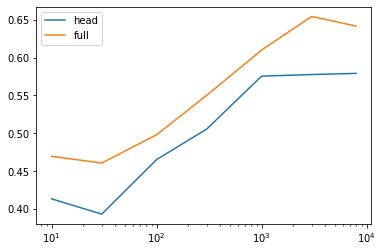

In [67]:
xs = np.array([10, 30, 100, 300, 1000, 3000, 7939])
plt.plot(xs, scores_50['head'])
plt.plot(xs, scores_50['full'])
plt.legend(['head', 'full'])
plt.xscale('log');

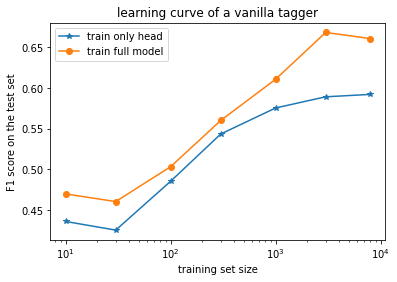

In [78]:
plt.plot(xs, scores_max['head'], marker='*')
plt.plot(xs, scores_max['full'], marker='o')
plt.legend(['train only head', 'train full model'])
#plt.scatter(xs, scores_max['head'])
#plt.scatter(xs, scores_max['full'])
plt.xscale('log');
plt.xlabel('training set size');
plt.ylabel('F1 score on the test set');
plt.title('learning curve of a vanilla tagger');

Result: the learning curve is steep, but not very steep really. 

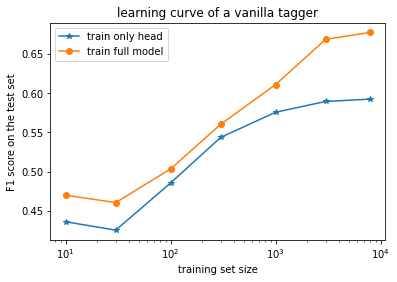

In [80]:
sm2 = [0.4698994695689647, 0.46052868203784997, 0.5033596644709653, 0.56008830890506, 0.6106484939446047, 0.6681581737239815, 0.6769273 ]

plt.plot(xs, scores_max['head'], marker='*')
plt.plot(xs, sm2, marker='o')
plt.legend(['train only head', 'train full model'])
#plt.scatter(xs, scores_max['head'])
#plt.scatter(xs, scores_max['full'])
plt.xscale('log');
plt.xlabel('training set size');
plt.ylabel('F1 score on the test set');
plt.title('learning curve of a vanilla tagger');

# Fine-tune the head-first classifier

In [82]:
for k in [10, 30, 100, 300, 1000, 3000, 10000]:
    print(f'Training model on {k} examples')
    print(datetime.now())
    model = AutoModelForTokenClassification.from_pretrained('models/roberta_clf_proba')
    cleanup()
    model.to(device);
    # first part
    for param in model.roberta.parameters():
        param.requires_grad = False
    MODEL_NAME = f'./models_scale_ft/roberta_single_{k}'
    training_args = TrAr(
        output_dir=MODEL_NAME,   # output directory
        overwrite_output_dir=True,
        num_train_epochs=100_000,            # total # of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=8,   # batch size for evaluation
        warmup_steps=3000,               # number of warmup steps for learning rate scheduler
        weight_decay=1e-8,              # strength of weight decay
        learning_rate=1e-3,
        logging_dir='./logs2',           # directory for storing logs
        logging_steps=50,
        eval_steps=50,
        evaluation_strategy='steps',
        save_total_limit=1,
        load_best_model_at_end=True,
    )
    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_sets[k],         # training dataset
        eval_dataset=eval_dataset,           # evaluation dataset
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0)]
    )
    trainer.train()
    model.save_pretrained(MODEL_NAME + '_head')
    loss_head = trainer.evaluate()['eval_loss']
    
    for param in model.parameters():
        param.requires_grad = True
    print(f'Tuning model on {k} examples')
    training_args = TrAr(
        output_dir=MODEL_NAME,   # output directory
        overwrite_output_dir=True,
        num_train_epochs=100_000,            # total # of training epochs
        per_device_train_batch_size=8,  # batch size per device during training
        per_device_eval_batch_size=8,   # batch size for evaluation
        warmup_steps=3000,               # number of warmup steps for learning rate scheduler
        weight_decay=1e-8,              # strength of weight decay
        learning_rate=1e-5,
        logging_dir='./logs2',           # directory for storing logs
        logging_steps=50,
        eval_steps=50,
        evaluation_strategy='steps',
        save_total_limit=1,
        load_best_model_at_end=True,
    )
    trainer = Trainer(
        model=model,                         # the instantiated 🤗 Transformers model to be trained
        args=training_args,                  # training arguments, defined above
        train_dataset=train_sets[k],         # training dataset
        eval_dataset=eval_dataset,           # evaluation dataset
        data_collator=data_collator,
        tokenizer=tokenizer,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5, early_stopping_threshold=0)]
    )
    trainer.train()
    loss_full = trainer.evaluate()['eval_loss']
    model.save_pretrained(MODEL_NAME + '_full')
    cleanup()
    print(f'Tuning model on {k} examples completed: losses {loss_head} -> {loss_full}')
    print(datetime.now())

Training model on 10 examples
2021-02-20 01:07:34.780623


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.671100,3.742878,2.303200,299.579000
100,3.531300,3.541786,2.090000,330.147000
150,3.365900,3.212573,2.030600,339.803000
200,3.006000,2.759046,2.073400,332.779000
250,2.442600,2.190272,2.533700,272.332000
300,1.783800,1.556592,2.309600,298.747000
350,1.149300,0.916740,2.251600,306.454000
400,0.636600,0.447749,2.167200,318.378000
450,0.335400,0.277569,2.301400,299.817000
500,0.310600,0.265539,2.259600,305.361000


Tuning model on 10 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.246900,0.267870,2.444200,282.297000
100,0.251100,0.270596,2.204200,313.039000
150,0.229100,0.281989,2.133200,323.462000
200,0.178200,0.286171,2.272100,303.686000
250,0.180100,0.263646,2.291800,301.075000
300,0.138200,0.311099,2.145100,321.661000
350,0.105100,0.338086,2.240900,307.906000
400,0.058000,0.457365,2.203000,313.215000
450,0.030800,0.551403,2.131300,323.740000
500,0.017200,0.699642,2.249200,306.772000


Tuning model on 10 examples completed: losses 0.2621999680995941 -> 0.26364636421203613
2021-02-20 01:10:49.874898
Training model on 30 examples
2021-02-20 01:10:49.875003


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.540200,3.743421,2.232000,309.139000
100,3.353200,3.543605,2.352000,293.370000
150,3.145500,3.208730,2.186400,315.581000
200,2.784200,2.742664,2.163600,318.920000
250,2.240400,2.163797,2.170000,317.975000
300,1.676400,1.507373,2.127400,324.344000
350,1.086100,0.868598,2.158900,319.608000
400,0.606000,0.411867,2.247100,307.068000
450,0.379000,0.273609,2.454000,281.169000
500,0.334900,0.261729,2.220000,310.811000


Tuning model on 30 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.209600,0.264818,2.226400,309.918000
100,0.208800,0.267497,2.139300,322.540000
150,0.189700,0.270546,2.196200,314.180000
200,0.173300,0.275621,2.209300,312.323000
250,0.146300,0.276973,2.227600,309.756000
300,0.122200,0.284137,2.283600,302.158000


Tuning model on 30 examples completed: losses 0.25823673605918884 -> 0.264818400144577
2021-02-20 01:13:43.579102
Training model on 100 examples
2021-02-20 01:13:43.579159


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.361200,3.742576,2.097800,328.915000
100,3.213200,3.542796,2.112400,326.647000
150,3.070700,3.207848,2.193000,314.636000
200,2.654200,2.748417,2.243200,307.592000
250,2.273100,2.165669,2.254200,306.098000
300,1.646900,1.505335,2.245400,307.293000
350,1.069500,0.865241,2.175500,317.162000
400,0.627400,0.436571,2.132800,323.511000
450,0.474300,0.293255,2.118600,325.691000
500,0.436700,0.271873,2.164700,318.748000


Tuning model on 100 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.310300,0.243599,2.175500,317.166000
100,0.298900,0.239783,2.406300,286.745000
150,0.297400,0.237974,2.130400,323.884000
200,0.276700,0.232960,2.566500,268.844000
250,0.253800,0.227285,2.163500,318.925000
300,0.248000,0.223148,2.582200,267.213000
350,0.220100,0.223663,2.150600,320.839000
400,0.203300,0.227810,2.350900,293.505000
450,0.188000,0.251761,2.187000,315.506000
500,0.153300,0.266655,2.317900,297.680000


Tuning model on 100 examples completed: losses 0.24335314333438873 -> 0.22314828634262085
2021-02-20 01:19:10.848502
Training model on 300 examples
2021-02-20 01:19:10.848587


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.450600,3.741568,2.298300,300.221000
100,3.371400,3.538293,2.253100,306.251000
150,3.237200,3.201840,2.224400,310.199000
200,2.810700,2.735645,2.240300,307.997000
250,2.276100,2.154271,2.094900,329.375000
300,1.716900,1.487816,2.077500,332.134000
350,1.102200,0.846201,2.318700,297.585000
400,0.607800,0.415089,2.298600,300.187000
450,0.378800,0.275097,2.327800,296.416000
500,0.350900,0.266092,2.319800,297.442000


Tuning model on 300 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.275800,0.213627,2.131500,323.717000
100,0.251900,0.210638,2.236900,308.458000
150,0.235800,0.207265,2.162900,319.011000
200,0.234600,0.203485,2.252400,306.346000
250,0.231600,0.202754,2.227700,309.734000
300,0.280100,0.199530,2.258500,305.518000
350,0.234100,0.199157,2.210400,312.161000
400,0.239200,0.204908,2.142700,322.023000
450,0.229000,0.209430,2.286100,301.819000
500,0.233400,0.207157,2.283900,302.115000


Tuning model on 300 examples completed: losses 0.21425467729568481 -> 0.19915743172168732
2021-02-20 01:27:24.007711
Training model on 1000 examples
2021-02-20 01:27:24.007778


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.573600,3.743064,2.329000,296.261000
100,3.440000,3.538656,2.302500,299.674000
150,3.268000,3.200797,2.207900,312.516000
200,2.800500,2.728882,2.144300,321.790000
250,2.255400,2.156054,2.106400,327.568000
300,1.699200,1.499682,2.098300,328.838000
350,1.123800,0.857961,2.126200,324.527000
400,0.586300,0.413368,2.170400,317.911000
450,0.345400,0.277082,2.366100,291.616000
500,0.313800,0.264744,2.458800,280.619000


Tuning model on 1000 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.226200,0.203137,2.108300,327.276000
100,0.264200,0.201077,2.344900,294.251000
150,0.218000,0.200352,2.385300,289.275000
200,0.278100,0.193325,2.125700,324.599000
250,0.232500,0.191051,2.149200,321.050000
300,0.226600,0.192937,2.253100,306.239000
350,0.280200,0.189524,2.166500,318.491000
400,0.228900,0.189090,2.202600,313.270000
450,0.228000,0.189227,2.206100,312.771000
500,0.203500,0.187875,2.312700,298.350000


Tuning model on 1000 examples completed: losses 0.204934224486351 -> 0.17938759922981262
2021-02-20 01:37:12.545243
Training model on 3000 examples
2021-02-20 01:37:12.545303


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.562100,3.741322,2.338700,295.039000
100,3.451200,3.538159,2.250900,306.542000
150,3.166300,3.197766,2.250700,306.577000
200,2.811700,2.730886,2.290400,301.257000
250,2.327600,2.135101,2.113400,326.484000
300,1.737700,1.470904,2.214400,311.596000
350,1.102900,0.826959,2.230700,309.323000
400,0.589200,0.403051,2.135300,323.140000
450,0.331300,0.272875,2.134000,323.329000
500,0.282900,0.264494,2.092200,329.802000


Tuning model on 3000 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.244600,0.194462,2.196200,314.176000
100,0.197400,0.193031,2.126700,324.444000
150,0.282200,0.189310,2.220100,310.798000
200,0.193400,0.190623,2.301000,299.865000
250,0.264300,0.187531,2.116700,325.982000
300,0.226300,0.191361,2.473600,278.948000
350,0.235300,0.188889,2.250200,306.639000
400,0.258400,0.183325,2.180200,316.479000
450,0.202100,0.183842,2.103900,327.964000
500,0.203400,0.187952,2.253200,306.230000


Tuning model on 3000 examples completed: losses 0.19416707754135132 -> 0.18332481384277344
2021-02-20 01:47:18.710052
Training model on 10000 examples
2021-02-20 01:47:18.710249


Some weights of the model checkpoint at models/roberta_clf_proba were not used when initializing RobertaForTokenClassification: ['wmean.pow', 'wmean.coef']
- This IS expected if you are initializing RobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,3.611200,3.741199,2.197900,313.941000
100,3.562200,3.536371,2.239800,308.058000
150,3.258400,3.200608,2.101700,328.308000
200,2.895500,2.730001,2.084700,330.976000
250,2.332800,2.157855,2.256500,305.785000
300,1.722500,1.492224,2.305000,299.354000
350,1.091100,0.857540,2.496500,276.385000
400,0.608600,0.411726,2.368300,291.350000
450,0.347200,0.276828,2.201500,313.417000
500,0.296300,0.264044,2.161000,319.294000


Tuning model on 10000 examples


Step,Training Loss,Validation Loss,Runtime,Samples Per Second
50,0.315000,0.202757,2.234200,308.841000
100,0.219300,0.198357,2.363900,291.890000
150,0.239500,0.196678,2.235800,308.613000
200,0.244400,0.189432,2.109800,327.047000
250,0.210900,0.190214,2.357100,292.735000
300,0.283900,0.189263,2.328500,296.323000
350,0.220100,0.188858,2.325500,296.706000
400,0.299300,0.187523,2.205000,312.926000
450,0.239400,0.183243,2.325800,296.673000
500,0.215100,0.185570,2.371700,290.925000


Tuning model on 10000 examples completed: losses 0.20201201736927032 -> 0.17184236645698547
2021-02-20 01:57:22.560936


## Evaluate

In [83]:
scores_50_ft = {
    'head': [],
    'full': []
}
scores_max_ft = {
    'head': [],
    'full': []
}

for k in [10, 30, 100, 300, 1000, 3000, 10000]:
    for mode in ['head', 'full']:
        MODEL_NAME = f'./models_scale_ft/roberta_single_{k}_{mode}'
        model = AutoModelForTokenClassification.from_pretrained(MODEL_NAME)
        cleanup()
        model.to(device);
        model.eval();

        training_args = TrAr(
            output_dir='tmp',
            per_device_eval_batch_size=64,   # batch size for evaluation
        )
        trainer = Trainer(
            model=model,                         # the instantiated 🤗 Transformers model to be trained
            args=training_args,                  # training arguments, defined above
            train_dataset=train_sets[k],         # training dataset
            data_collator=data_collator,
            tokenizer=tokenizer,
        )
        pred = trainer.predict(final_test_dataset)
        scores = []
        for threshold in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
            preds = []
            for text, pr in zip(final_test.text, pred.predictions):
                proba = np.exp(pr[pr[:, 0]!=-100])
                proba /= proba.sum(axis=1, keepdims=True)
                labels = (proba[:, 1] >= threshold).astype(int).tolist()
                preds.append(labels2spans(text, labels, tokenizer))
            score = np.mean([f1(p, y) for p, y in zip(preds, final_test.spans)])
            scores.append(score)
            if threshold == 0.5:
                score_50 = score
        score_max = max(scores)
        print(k, mode, score_50, score_max)
        scores_50_ft[mode].append(score_50)
        scores_max_ft[mode].append(score_max)

10 head 0.20996358946778593 0.24778191428625018


10 full 0.4558391877431416 0.48412770986043197


30 head 0.19665258203054256 0.24015520569320026


30 full 0.43972790342989826 0.4410907253856781


100 head 0.19426943388289686 0.38145677664626454


100 full 0.5722858622974533 0.5722858622974533


300 head 0.2249463028813179 0.5484361004401123


300 full 0.6344381401889334 0.6352267779114283


1000 head 0.2711240067635228 0.5619014200066833


1000 full 0.6527472992730478 0.6586461703712368


3000 head 0.22743156478529175 0.6100396795764801


3000 full 0.6517859231684686 0.657493664504611


10000 head 0.20691776409080218 0.5795356023564205


10000 full 0.6577082315501016 0.6685484505957388


In [164]:
print(scores_50_ft)
#{'head': [0.20996358946778593, 0.19665258203054256, 0.19426943388289686, 0.2249463028813179, 0.2711240067635228, 0.22743156478529175, 0.20691776409080218], 'full': [0.4558391877431416, 0.43972790342989826, 0.5722858622974533, 0.6344381401889334, 0.6527472992730478, 0.6517859231684686, 0.6577082315501016]}

{'head': [0.20996358946778593, 0.19665258203054256, 0.19426943388289686, 0.2249463028813179, 0.2711240067635228, 0.22743156478529175, 0.20691776409080218], 'full': [0.4558391877431416, 0.43972790342989826, 0.5722858622974533, 0.6344381401889334, 0.6527472992730478, 0.6517859231684686, 0.6577082315501016]}


In [166]:
print(scores_max_ft)
# {'head': [0.24778191428625018, 0.24015520569320026, 0.38145677664626454, 0.5484361004401123, 0.5619014200066833, 0.6100396795764801, 0.5795356023564205], 'full': [0.48412770986043197, 0.4410907253856781, 0.5722858622974533, 0.6352267779114283, 0.6586461703712368, 0.657493664504611, 0.6685484505957388]}

{'head': [0.24778191428625018, 0.24015520569320026, 0.38145677664626454, 0.5484361004401123, 0.5619014200066833, 0.6100396795764801, 0.5795356023564205], 'full': [0.48412770986043197, 0.4410907253856781, 0.5722858622974533, 0.6352267779114283, 0.6586461703712368, 0.657493664504611, 0.6685484505957388]}


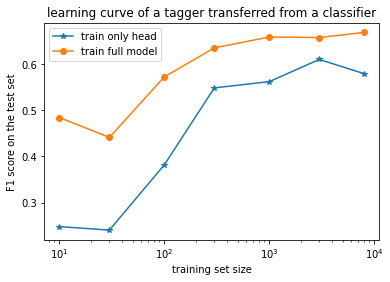

In [86]:
plt.plot(xs, scores_max_ft['head'], marker='*')
plt.plot(xs, scores_max_ft['full'], marker='o')
plt.legend(['train only head', 'train full model'])
#plt.scatter(xs, scores_max['head'])
#plt.scatter(xs, scores_max['full'])
plt.xscale('log');
plt.xlabel('training set size');
plt.ylabel('F1 score on the test set');
plt.title('learning curve of a tagger transferred from a classifier');

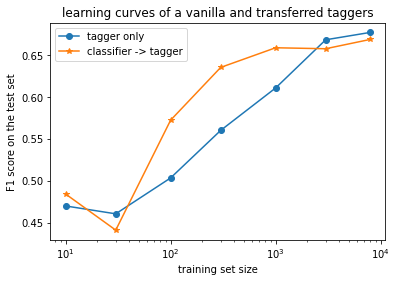

In [104]:
sm2 = [0.4698994695689647, 0.46052868203784997, 0.5033596644709653, 0.56008830890506, 0.6106484939446047, 0.6681581737239815, 0.6769273 ]

#fig = plt.figure(figsize=(3, 3))
plt.plot(xs, sm2, marker='o')
plt.plot(xs, scores_max_ft['full'], marker='*')
plt.legend(['tagger only', 'classifier -> tagger'])
#plt.scatter(xs, scores_max['head'])
#plt.scatter(xs, scores_max['full'])
plt.xscale('log');
plt.xlabel('training set size');
plt.ylabel('F1 score on the test set');
plt.title('learning curves of a vanilla and transferred taggers');

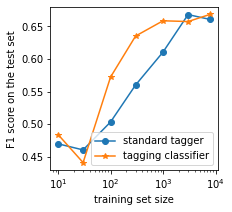

In [137]:
sm2 = [0.4698994695689647, 0.46052868203784997, 0.5033596644709653, 0.56008830890506, 0.6106484939446047, 0.6681581737239815, 0.6769273 ]

fig, ax = plt.subplots(figsize=(3,3))

plt.plot(xs, scores_max['full'], marker='o')
plt.plot(xs, scores_max_ft['full'], marker='*')

plt.legend(['standard tagger', 'tagging classifier'])
#plt.scatter(xs, scores_max['head'])
#plt.scatter(xs, scores_max['full'])
plt.xscale('log');
plt.xlabel('training set size');
plt.ylabel('F1 score on the test set');
#plt.title('learning curves of a vanilla and transferred taggers');

#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500));
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(500));

plt.savefig('images/curve.png', dpi=300, transparent=False, bbox_inches='tight')

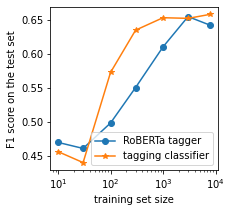

In [161]:
sm2 = [0.4698994695689647, 0.46052868203784997, 0.5033596644709653, 0.56008830890506, 0.6106484939446047, 0.6681581737239815, 0.6769273 ]

fig, ax = plt.subplots(figsize=(3,3))

plt.plot(xs, scores_50['full'], marker='o')
plt.plot(xs, scores_50_ft['full'], marker='*')

plt.legend(['RoBERTa tagger', 'tagging classifier'])
#plt.scatter(xs, scores_max['head'])
#plt.scatter(xs, scores_max['full'])
plt.xscale('log');
plt.xlabel('training set size');
plt.ylabel('F1 score on the test set');
#plt.title('learning curves of a vanilla and transferred taggers');

#ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500));
#ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(500));

plt.savefig('images/curve.png', dpi=300, transparent=False, bbox_inches='tight')

# Toxic vocabulary size

In [160]:
def get_substrings(character_ids, text, inverse=False):
    """ extract contiguous spans from text given by character_ids"""
    if inverse:
        character_ids = 
    if not character_ids:
        return []
    prev = -100
    w = []
    result = []
    for idx in character_ids:
        if prev >=0 and idx > prev + 1:
            result.append(''.join(w))
            w = []
        if idx < len(text):
            w.append(text[idx])
        prev = idx
    if w:
        result.append(''.join(w))
    return result

print(get_substrings(train.spans[0], train.text[0]))
print()

['violent and aggressive immigrant']


In [99]:
train_ordered = train.iloc[indices]

familiar = []
vocab_sizes = []
vocab = set()

for i, row in train_ordered.iterrows():
    subs = get_substrings(row.spans, row.text.lower())
    if subs:
        words = [w for s in subs for w in s.strip().split() if w]
        familiar.append(np.mean([w in vocab for w in words]))
        vocab.update(words)
        vocab_sizes.append(len(vocab))

In [123]:
import matplotlib as mpl

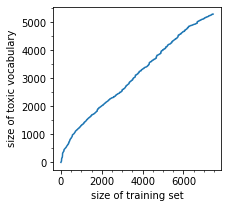

In [139]:
fig, ax = plt.subplots(figsize=(3,3))

pd.Series(vocab_sizes).plot();
# plt.plot([0, len(vocab_sizes)], [0, len(vocab)])
# plt.title('Proportion of toxic vocabulary over time');
plt.xlabel('size of training set');
plt.ylabel('size of toxic vocabulary');

ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(500));
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(500));

plt.savefig('images/vocab.png', dpi=300, transparent=False, bbox_inches='tight')

0.9243431060344433


Text(0.5, 1.0, 'proportion of toxic words which are familiar')

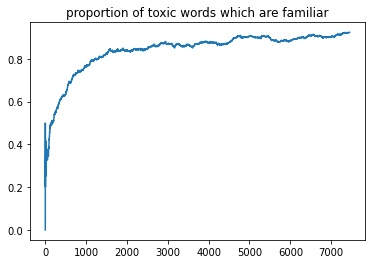

In [108]:
s = pd.Series(familiar).rolling(500, min_periods=1).mean()
print(s.max())

s.plot();
plt.title('proportion of toxic words which are familiar')

In [148]:
np.mean(familiar[-500:])

0.923421028112365

In [142]:
import nltk

In [144]:
sentlen = pd.Series([len(nltk.sent_tokenize(t)) for t in train.text])
sentlen.describe()

count    7939.000000
mean        2.889533
std         2.336196
min         1.000000
25%         1.000000
50%         2.000000
75%         4.000000
max        26.000000
dtype: float64

In [145]:
sentlen.median()

2.0

In [146]:
sentlen.value_counts()

1     2504
2     2074
3     1253
4      779
5      429
6      296
7      187
8      131
9      100
10      60
11      41
12      28
13      20
14      16
15       7
16       6
17       3
23       1
20       1
18       1
26       1
25       1
dtype: int64